In [1]:
# the dataset https://www.kaggle.com/datasets/altavish/boston-housing-dataset/data
import numpy as np
import pandas as pd
import cvxpy as cp
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('HousingData.csv')
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


In [3]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,486.000000,486.000000,486.000000,486.000000,506.000000,506.000000,486.000000,506.000000,506.000000,506.000000,506.000000,506.000000,486.000000,506.000000
mean,3.611874,11.211934,11.083992,0.069959,0.554695,6.284634,68.518519,3.795043,9.549407,408.237154,18.455534,356.674032,12.715432,22.532806
std,8.720192,23.388876,6.835896,0.255340,0.115878,0.702617,27.999513,2.105710,8.707259,168.537116,2.164946,91.294864,7.155871,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.081900,0.000000,5.190000,0.000000,0.449000,5.885500,45.175000,2.100175,4.000000,279.000000,17.400000,375.377500,7.125000,17.025000
50%,0.253715,0.000000,9.690000,0.000000,0.538000,6.208500,76.800000,3.207450,5.000000,330.000000,19.050000,391.440000,11.430000,21.200000
75%,3.560263,12.500000,18.100000,0.000000,0.624000,6.623500,93.975000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [4]:
df = df.dropna()

## No noise, original data

In order to minimize the numerical error that might occur due to the different implementations, we have implemented everything using cvxpy

### Regular Linear Regression

In [5]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

In [7]:
class LinearRegression:
    def __init__(self):
        self.w = None
        
    def fit(self, X, y):
        lenw = X.shape[1]
        numK = X.shape[0]
        w = cp.Variable(lenw)
        residuals = y - X @ w
        objective = cp.Minimize(cp.sum(cp.square(cp.abs(residuals))))
        prob = cp.Problem(objective)
        prob.solve()
        self.w = w.value

    def predict(self, X):
        return X @ self.w

In [6]:
N_SPLITS = 5
RESULT_METRICS = {}
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=125)

y = df["MEDV"].to_numpy()
X = df.drop("MEDV", axis=1).to_numpy()

In [9]:
avg_mape = 0
avg_mse = 0
avg_r2 = 0
for i, s in enumerate(kf.split(df)):
    X_train = X[s[0]]
    y_train = y[s[0]].reshape(-1, 1)
    X_test = X[s[1]]
    y_test = y[s[1]].reshape(-1, 1)

    X_scaler = StandardScaler()
    X_train = X_scaler.fit_transform(X_train)
    X_test = X_scaler.transform(X_test)
    y_scaler = StandardScaler()
    y_train = y_scaler.fit_transform(y_train).ravel()
    y_test = y_scaler.transform(y_test).ravel()

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    print(f'Split {i}')
    print(f'\tMAPE={mean_absolute_percentage_error(y_test, y_pred)}')
    print(f'\tMSE={mean_squared_error(y_test, y_pred)}')
    print(f'\tR2={r2_score(y_test, y_pred)}')
    print()
    avg_mape += mean_absolute_percentage_error(y_test, y_pred)
    avg_mse += mean_squared_error(y_test, y_pred)
    avg_r2 += r2_score(y_test, y_pred)
avg_mape /= N_SPLITS
avg_mse /= N_SPLITS
avg_r2 /= N_SPLITS

print(f'Average MAPE={avg_mape}')
print(f'Average MSE={avg_mse}')
print(f'Average R2={avg_r2}')

RESULT_METRICS["Linear Regression"] = {}
RESULT_METRICS["Linear Regression"]["mape"] = avg_mape
RESULT_METRICS["Linear Regression"]["mse"] = avg_mse
RESULT_METRICS["Linear Regression"]["r2"] = avg_r2

Split 0
	MAPE=1.5842985578155324
	MSE=0.29793200292679567
	R2=0.7133669787909805

Split 1
	MAPE=1.0882261436238827
	MSE=0.16857052476429843
	R2=0.8094255819573808

Split 2
	MAPE=2.704765171940073
	MSE=0.20619336258133558
	R2=0.7942683386750646

Split 3
	MAPE=1.598818861521577
	MSE=0.3049120151863113
	R2=0.7198166382603508

Split 4
	MAPE=2.322285135201998
	MSE=0.3428117536730135
	R2=0.6404315211187315

Average MAPE=1.8596787740206124
Average MSE=0.2640839318263509
Average R2=0.7354618117605017


### Try robust implementations: Ridge, HuberRegressor, Lasso

In [14]:
class LassoLR:
    def __init__(self, delta):
        self.w = None
        self.delta = delta
        
    def fit(self, X, y):
        lenw = X.shape[1]
        numK = X.shape[0]
        w = cp.Variable(lenw)
        residuals = y - X @ w
        objective = cp.Minimize(cp.sum(cp.square(cp.abs(residuals))) + self.delta * cp.norm(w, 1))
        prob = cp.Problem(objective)
        prob.solve()
        self.w = w.value

    def predict(self, X):
        return X @ self.w
    
class RidgeLR:
    def __init__(self, delta):
        self.w = None
        self.delta = delta
        
    def fit(self, X, y):
        lenw = X.shape[1]
        numK = X.shape[0]
        w = cp.Variable(lenw)
        residuals = y - X @ w
        objective = cp.Minimize(cp.sum(cp.square(cp.abs(residuals))) + self.delta * cp.norm(w, 2))
        prob = cp.Problem(objective)
        prob.solve()
        self.w = w.value

    def predict(self, X):
        return X @ self.w
    
class HuberLR:
    def __init__(self, delta):
        self.w = None
        self.delta = delta
        
    def fit(self, X, y):
        lenw = X.shape[1]
        numK = X.shape[0]
        w = cp.Variable(lenw)
        residuals = y - X @ w
        objective = cp.Minimize(cp.sum(cp.huber(residuals, self.delta)))
        prob = cp.Problem(objective)
        prob.solve()
        self.w = w.value

    def predict(self, X):
        return X @ self.w

In [12]:
avg_mape = 0
avg_mse = 0
avg_r2 = 0

DELTA = 1e-2

for i, s in enumerate(kf.split(df)):
    X_train = X[s[0]]
    y_train = y[s[0]].reshape(-1, 1)
    X_test = X[s[1]]
    y_test = y[s[1]].reshape(-1, 1)

    X_scaler = StandardScaler()
    X_train = X_scaler.fit_transform(X_train)
    X_test = X_scaler.transform(X_test)
    y_scaler = StandardScaler()
    y_train = y_scaler.fit_transform(y_train).ravel()
    y_test = y_scaler.transform(y_test).ravel()
    
    lr = LassoLR(DELTA)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    print(f'Split {i}')
    print(f'\tMAPE={mean_absolute_percentage_error(y_test, y_pred)}')
    print(f'\tMSE={mean_squared_error(y_test, y_pred)}')
    print(f'\tR2={r2_score(y_test, y_pred)}')
    print()
    avg_mape += mean_absolute_percentage_error(y_test, y_pred)
    avg_mse += mean_squared_error(y_test, y_pred)
    avg_r2 += r2_score(y_test, y_pred)
avg_mape /= N_SPLITS
avg_mse /= N_SPLITS
avg_r2 /= N_SPLITS

print(f'Average MAPE={avg_mape}')
print(f'Average MSE={avg_mse}')
print(f'Average R2={avg_r2}')

RESULT_METRICS["Lasso"] = {}
RESULT_METRICS["Lasso"]["mape"] = avg_mape
RESULT_METRICS["Lasso"]["mse"] = avg_mse
RESULT_METRICS["Lasso"]["r2"] = avg_r2

Split 0
	MAPE=1.584035841533684
	MSE=0.29791936850098466
	R2=0.7133791340599878

Split 1
	MAPE=1.0877087469902007
	MSE=0.16856762782113985
	R2=0.8094288570451065

Split 2
	MAPE=2.704634351991241
	MSE=0.20618604224267562
	R2=0.794275642622268

Split 3
	MAPE=1.598956019556854
	MSE=0.30492141737107553
	R2=0.719807998601683

Split 4
	MAPE=2.322164745389071
	MSE=0.3428095939867165
	R2=0.6404337863710408

Average MAPE=1.8594999410922104
Average MSE=0.26408080998451844
Average R2=0.7354650837400172


In [15]:
avg_mape = 0
avg_mse = 0
avg_r2 = 0

DELTA = 1e-2

for i, s in enumerate(kf.split(df)):
    X_train = X[s[0]]
    y_train = y[s[0]].reshape(-1, 1)
    X_test = X[s[1]]
    y_test = y[s[1]].reshape(-1, 1)

    X_scaler = StandardScaler()
    X_train = X_scaler.fit_transform(X_train)
    X_test = X_scaler.transform(X_test)
    y_scaler = StandardScaler()
    y_train = y_scaler.fit_transform(y_train).ravel()
    y_test = y_scaler.transform(y_test).ravel()

    lr = HuberLR(DELTA)
    lr.fit(X_train, y_train.ravel())
    y_pred = lr.predict(X_test)
    print(f'Split {i}')
    print(f'\tMAPE={mean_absolute_percentage_error(y_test, y_pred)}')
    print(f'\tMSE={mean_squared_error(y_test, y_pred)}')
    print(f'\tR2={r2_score(y_test, y_pred)}')
    print()
    avg_mape += mean_absolute_percentage_error(y_test, y_pred)
    avg_mse += mean_squared_error(y_test, y_pred)
    avg_r2 += r2_score(y_test, y_pred)
avg_mape /= N_SPLITS
avg_mse /= N_SPLITS
avg_r2 /= N_SPLITS

print(f'Average MAPE={avg_mape}')
print(f'Average MSE={avg_mse}')
print(f'Average R2={avg_r2}')

RESULT_METRICS["Huber"] = {}
RESULT_METRICS["Huber"]["mape"] = avg_mape
RESULT_METRICS["Huber"]["mse"] = avg_mse
RESULT_METRICS["Huber"]["r2"] = avg_r2

Split 0
	MAPE=1.6003379937956268
	MSE=0.3195602082515188
	R2=0.6925590166564877

Split 1
	MAPE=0.8969274363054673
	MSE=0.15710151472682302
	R2=0.8223916679114524

Split 2
	MAPE=2.355896277385706
	MSE=0.1923288963972244
	R2=0.8081017600118714

Split 3
	MAPE=1.7685311994503683
	MSE=0.3204928313907877
	R2=0.7054994410185486

Split 4
	MAPE=2.2276082427631447
	MSE=0.36339369917623504
	R2=0.6188435249146411

Average MAPE=1.7698602299400625
Average MSE=0.2705754299885178
Average R2=0.7294790821026002


In [16]:
avg_mape = 0
avg_mse = 0
avg_r2 = 0

DELTA = 1e-2

for i, s in enumerate(kf.split(df)):
    X_train = X[s[0]]
    y_train = y[s[0]].reshape(-1, 1)
    X_test = X[s[1]]
    y_test = y[s[1]].reshape(-1, 1)

    X_scaler = StandardScaler()
    X_train = X_scaler.fit_transform(X_train)
    X_test = X_scaler.transform(X_test)
    y_scaler = StandardScaler()
    y_train = y_scaler.fit_transform(y_train).ravel()
    y_test = y_scaler.transform(y_test).ravel()

    lr = RidgeLR(DELTA)
    lr.fit(X_train, y_train.ravel())
    y_pred = lr.predict(X_test)
    print(f'Split {i}')
    print(f'\tMAPE={mean_absolute_percentage_error(y_test, y_pred)}')
    print(f'\tMSE={mean_squared_error(y_test, y_pred)}')
    print(f'\tR2={r2_score(y_test, y_pred)}')
    print()
    avg_mape += mean_absolute_percentage_error(y_test, y_pred)
    avg_mse += mean_squared_error(y_test, y_pred)
    avg_r2 += r2_score(y_test, y_pred)
avg_mape /= N_SPLITS
avg_mse /= N_SPLITS
avg_r2 /= N_SPLITS

print(f'Average MAPE={avg_mape}')
print(f'Average MSE={avg_mse}')
print(f'Average R2={avg_r2}')

RESULT_METRICS["Ridge"] = {}
RESULT_METRICS["Ridge"]["mape"] = avg_mape
RESULT_METRICS["Ridge"]["mse"] = avg_mse
RESULT_METRICS["Ridge"]["r2"] = avg_r2

Split 0
	MAPE=1.584244631405095
	MSE=0.2979288315034767
	R2=0.7133700299390228

Split 1
	MAPE=1.08807836411212
	MSE=0.16857082176492172
	R2=0.809425246188592

Split 2
	MAPE=2.70470574350191
	MSE=0.20618865332527397
	R2=0.7942730373863182

Split 3
	MAPE=1.598841755513435
	MSE=0.3049162995862288
	R2=0.7198127013293276

Split 4
	MAPE=2.3222127370238836
	MSE=0.3428091835035233
	R2=0.6404342169187562

Average MAPE=1.8596166463112886
Average MSE=0.2640827579366849
Average R2=0.7354630463524033


### Robust Linear Regression

In [17]:
class RobustLR:
    def __init__(self, delta):
        self.w = None
        self.delta = delta
        
    def fit(self, X, y):
        lenw = X.shape[1]
        numK = X.shape[0]
        w = cp.Variable(lenw)
        residuals = y - X @ w
        objective = cp.Minimize(cp.sum(cp.square(cp.abs(residuals) + self.delta * cp.norm(w, 2))))
        prob = cp.Problem(objective)
        prob.solve()
        self.w = w.value

    def predict(self, X):
        return X @ self.w

In [18]:
DELTA = 1e-2

avg_mape = 0
avg_mse = 0
avg_r2 = 0

for i, s in enumerate(kf.split(df)):
    X_train = X[s[0]]
    y_train = y[s[0]].reshape(-1, 1)
    X_test = X[s[1]]
    y_test = y[s[1]].reshape(-1, 1)

    X_scaler = StandardScaler()
    X_train = X_scaler.fit_transform(X_train)
    X_test = X_scaler.transform(X_test)
    y_scaler = StandardScaler()
    y_train = y_scaler.fit_transform(y_train)
    y_test = y_scaler.transform(y_test)

    lr = RobustLR(delta=DELTA)
    lr.fit(X_train, y_train.ravel())
    y_pred = lr.predict(X_test)
    print(f'Split {i}')
    print(f'\tMAPE={mean_absolute_percentage_error(y_test, y_pred)}')
    print(f'\tMSE={mean_squared_error(y_test, y_pred)}')
    print(f'\tR2={r2_score(y_test, y_pred)}')
    print()
    avg_mape += mean_absolute_percentage_error(y_test, y_pred)
    avg_mse += mean_squared_error(y_test, y_pred)
    avg_r2 += r2_score(y_test, y_pred)
avg_mape /= N_SPLITS
avg_mse /= N_SPLITS
avg_r2 /= N_SPLITS

print(f'Average MAPE={avg_mape}')
print(f'Average MSE={avg_mse}')
print(f'Average R2={avg_r2}')

RESULT_METRICS["Robust LR"] = {}
RESULT_METRICS["Robust LR"]["mape"] = avg_mape
RESULT_METRICS["Robust LR"]["mse"] = avg_mse
RESULT_METRICS["Robust LR"]["r2"] = avg_r2

Split 0
	MAPE=1.5707863957945598
	MSE=0.29719590110795613
	R2=0.7140751641694518

Split 1
	MAPE=1.0575396937919215
	MSE=0.1687323511413038
	R2=0.8092426320160144

Split 2
	MAPE=2.6854697772740583
	MSE=0.20480689227769647
	R2=0.7956517044409381

Split 3
	MAPE=1.6056294652932823
	MSE=0.30593053054915015
	R2=0.718880725458852

Split 4
	MAPE=2.304631583714406
	MSE=0.34227376419645456
	R2=0.640995807656949

Average MAPE=1.8448113831736457
Average MSE=0.26378788785451224
Average R2=0.7357692067484412


### Compare different models

In [19]:
results = pd.DataFrame(RESULT_METRICS)
results

,Linear Regression,Lasso,Huber,Ridge,Robust LR
mape,1.859679,1.859500,1.769860,1.859617,1.844811
mse,0.264084,0.264081,0.270575,0.264083,0.263788
r2,0.735462,0.735465,0.729479,0.735463,0.735769


### Investigate how the value of `delta` influences the regression metrics on the original data

In [20]:
deltas = [1e-7, 1e-6, 1e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1]
mapes = []
mses = []
r2s = []

for delta in deltas:
    avg_mape = 0
    avg_mse = 0
    avg_r2 = 0
    for i, s in enumerate(kf.split(df)):
        X_train = X[s[0]]
        y_train = y[s[0]].reshape(-1, 1)
        X_test = X[s[1]]
        y_test = y[s[1]].reshape(-1, 1)

        X_scaler = StandardScaler()
        X_train = X_scaler.fit_transform(X_train)
        X_test = X_scaler.transform(X_test)
        y_scaler = StandardScaler()
        y_train = y_scaler.fit_transform(y_train).ravel()
        y_test = y_scaler.transform(y_test).ravel()

        lr = RobustLR(delta=delta)
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        avg_mape += mean_absolute_percentage_error(y_test, y_pred)
        avg_mse += mean_squared_error(y_test, y_pred)
        avg_r2 += r2_score(y_test, y_pred)
    mapes.append(avg_mape / N_SPLITS)
    mses.append(avg_mse / N_SPLITS)
    r2s.append(avg_r2 / N_SPLITS)

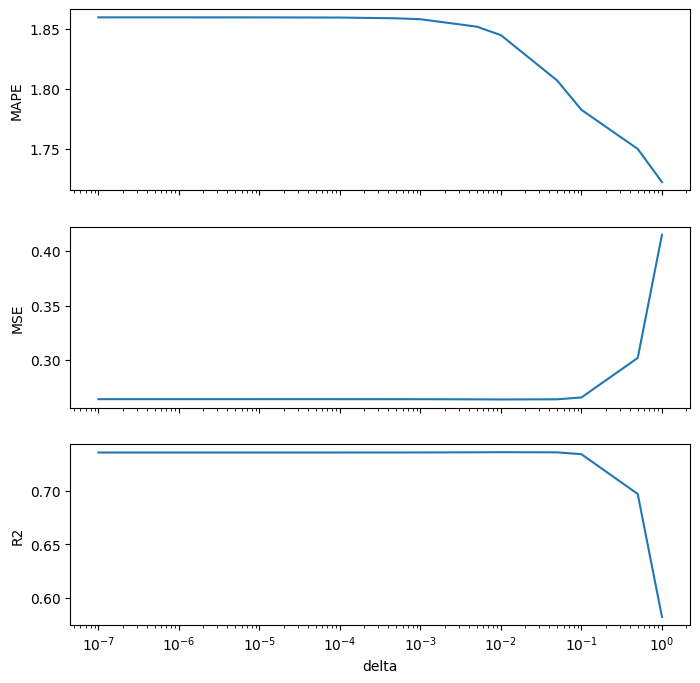

In [21]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(8, 8))
ax[0].plot(deltas, mapes)
ax[1].plot(deltas, mses)
ax[2].plot(deltas, r2s)
ax[0].set_ylabel('MAPE')
ax[1].set_ylabel('MSE')
ax[2].set_ylabel('R2')
plt.xlabel('delta')
plt.xscale('log')
plt.show()

## Add noise to the data

In [22]:
np.random.seed(125)

NOISE_DELTA = 1

In [27]:
DELTA = 1e-1

models = {"Linear Regression": LinearRegression,
          "Robust LR": RobustLR,
          "Huber": HuberLR,
          "Lasso": LassoLR,
          "Ridge": RidgeLR}

for model_name, model in models.items():
    np.random.seed(125)
    avg_mape = 0
    avg_mse = 0
    avg_r2 = 0
    for i, s in enumerate(kf.split(df)):
        X_train = X[s[0]]
        y_train = y[s[0]]
        X_test = X[s[1]]
        y_test = y[s[1]]

        X_scaler = StandardScaler()
        X_train = X_scaler.fit_transform(X_train)
        X_test = X_scaler.transform(X_test)
        y_scaler = StandardScaler()
        y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
        y_test = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

        N = np.random.normal(0, 1, X_train.shape)
        row_norms = np.linalg.norm(N, ord=2, axis=1, keepdims=True)
        D = np.diag (np.reciprocal(row_norms).ravel())
        N = np.matmul(D, N)
        X_train = X_train + N * NOISE_DELTA

        N = np.random.normal(0, 1, X_test.shape)
        row_norms = np.linalg.norm(N, ord=2, axis=1, keepdims=True)
        D = np.diag (np.reciprocal(row_norms).ravel())
        N = np.matmul(D, N)
        X_test = X_test + N * NOISE_DELTA
        
        if model_name == "Linear Regression":
            lr = model()
        else:
            lr = model(DELTA)
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)

        avg_mape += mean_absolute_percentage_error(y_test, y_pred)
        avg_mse += mean_squared_error(y_test, y_pred)
        avg_r2 += r2_score(y_test, y_pred)
    avg_mape /= N_SPLITS
    avg_mse /= N_SPLITS
    avg_r2 /= N_SPLITS

    print(model_name)
    print(f'Average MAPE={avg_mape}')
    print(f'Average MSE={avg_mse}')
    print(f'Average R2={avg_r2}')
    print()

    RESULT_METRICS[model_name]["noisy_mape"] = avg_mape
    RESULT_METRICS[model_name]["noisy_mse"] = avg_mse
    RESULT_METRICS[model_name]["noisy_r2"] = avg_r2

Linear Regression
Average MAPE=2.0917492344603765
Average MSE=0.2971616956360351
Average R2=0.70215450015971

Robust LR
Average MAPE=2.0372754084605673
Average MSE=0.29396748047189447
Average R2=0.7054702210332883

Huber
Average MAPE=2.040919102025316
Average MSE=0.2951257293929694
Average R2=0.7043554929443377

Lasso
Average MAPE=2.090748453925783
Average MSE=0.29710237321266664
Average R2=0.7022180206525861

Ridge
Average MAPE=2.0913963262798503
Average MSE=0.2971355810751629
Average R2=0.7021814639191815



In [28]:
results = pd.DataFrame(RESULT_METRICS)
results

,Linear Regression,Lasso,Huber,Ridge,Robust LR
mape,1.859679,1.859500,1.769860,1.859617,1.844811
mse,0.264084,0.264081,0.270575,0.264083,0.263788
r2,0.735462,0.735465,0.729479,0.735463,0.735769
noisy_mape,2.091749,2.090748,2.040919,2.091396,2.037275
noisy_mse,0.297162,0.297102,0.295126,0.297136,0.293967
noisy_r2,0.702155,0.702218,0.704355,0.702181,0.705470


## Compare the robustness to the different noise levels

In [56]:
NOISE_DELTAS = [1e-8, 1e-7, 1e-6, 1e-4, 1e-3, 1e-2, 5e-2, 1e-1, 1]
DELTA = 1e-1

models = {"Linear Regression": LinearRegression,
          "Robust LR": RobustLR,
          "Huber": HuberLR,
          "Lasso": LassoLR,
          "Ridge": RidgeLR}

mses = {k: [] for k in models.keys()}
mapes = {k: [] for k in models.keys()}

for noise_delta in NOISE_DELTAS:
    for model_name, model in models.items():
        np.random.seed(125)
        avg_mape = 0
        avg_mse = 0
        avg_r2 = 0
        for i, s in enumerate(kf.split(df)):
            X_train = X[s[0]]
            y_train = y[s[0]]
            X_test = X[s[1]]
            y_test = y[s[1]]

            X_scaler = StandardScaler()
            X_train = X_scaler.fit_transform(X_train)
            X_test = X_scaler.transform(X_test)
            y_scaler = StandardScaler()
            y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
            y_test = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

            N = np.random.normal(0, 1, X_train.shape)
            row_norms = np.linalg.norm(N, ord=2, axis=1, keepdims=True)
            D = np.diag (np.reciprocal(row_norms).ravel())
            N = np.matmul(D, N)
            X_train = X_train + N * noise_delta

            N = np.random.normal(0, 1, X_test.shape)
            row_norms = np.linalg.norm(N, ord=2, axis=1, keepdims=True)
            D = np.diag (np.reciprocal(row_norms).ravel())
            N = np.matmul(D, N)
            X_test = X_test + N * noise_delta
            
            if model_name == "Linear Regression":
                lr = model()
            else:
                lr = model(DELTA)
            lr.fit(X_train, y_train)
            y_pred = lr.predict(X_test)

            avg_mape += mean_absolute_percentage_error(y_test, y_pred)
            avg_mse += mean_squared_error(y_test, y_pred)
        avg_mape /= N_SPLITS
        avg_mse /= N_SPLITS

        mses[model_name].append(avg_mse)
        mapes[model_name].append(avg_mape)

c:\Users\amina\AppData\Local\Programs\Python\Python311\Lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\amina\AppData\Local\Programs\Python\Python311\Lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


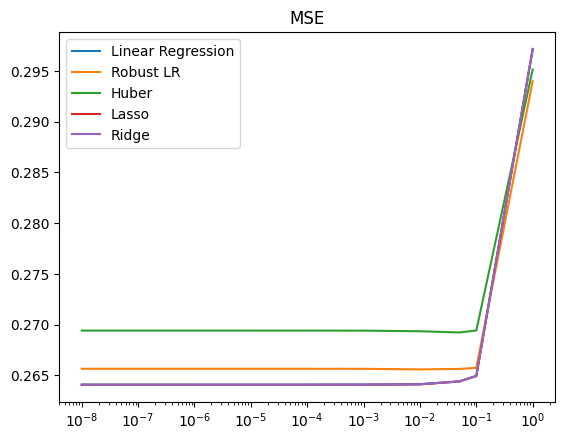

In [57]:
for model_name, mse in mses.items():
    plt.plot(NOISE_DELTAS, mse, label=model_name)
plt.xscale('log')
plt.legend()
plt.title("MSE")
plt.show()

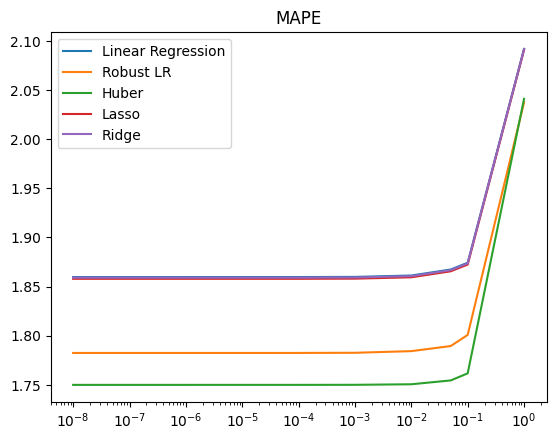

In [58]:
for model_name, mape in mapes.items():
    plt.plot(NOISE_DELTAS, mape, label=model_name)
plt.xscale('log')
plt.legend()
plt.title("MAPE")
plt.show()

### Compare different `delta` for RobustLR for different noise levels

In [62]:
NOISE_DELTAS = [1e-8, 1e-7, 1e-6, 1e-4, 1e-3, 1e-2, 5e-2, 1e-1, 1]
DELTAS = [1e-3, 1e-2, 5e-2, 1e-1, 3e-1, 5e-1]


mses = {f'delta={d}': [] for d in DELTAS}
mapes = {f'delta={d}': [] for d in DELTAS}

for noise_delta in NOISE_DELTAS:
    for d in DELTAS:
        np.random.seed(125)
        avg_mape = 0
        avg_mse = 0
        avg_r2 = 0
        for i, s in enumerate(kf.split(df)):
            X_train = X[s[0]]
            y_train = y[s[0]]
            X_test = X[s[1]]
            y_test = y[s[1]]

            X_scaler = StandardScaler()
            X_train = X_scaler.fit_transform(X_train)
            X_test = X_scaler.transform(X_test)
            y_scaler = StandardScaler()
            y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
            y_test = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

            N = np.random.normal(0, 1, X_train.shape)
            row_norms = np.linalg.norm(N, ord=2, axis=1, keepdims=True)
            D = np.diag (np.reciprocal(row_norms).ravel())
            N = np.matmul(D, N)
            X_train = X_train + N * noise_delta

            N = np.random.normal(0, 1, X_test.shape)
            row_norms = np.linalg.norm(N, ord=2, axis=1, keepdims=True)
            D = np.diag (np.reciprocal(row_norms).ravel())
            N = np.matmul(D, N)
            X_test = X_test + N * noise_delta
            
            lr = RobustLR(d)
            lr.fit(X_train, y_train)
            y_pred = lr.predict(X_test)

            avg_mape += mean_absolute_percentage_error(y_test, y_pred)
            avg_mse += mean_squared_error(y_test, y_pred)
        avg_mape /= N_SPLITS
        avg_mse /= N_SPLITS

        mses[f'delta={d}'].append(avg_mse)
        mapes[f'delta={d}'].append(avg_mape)

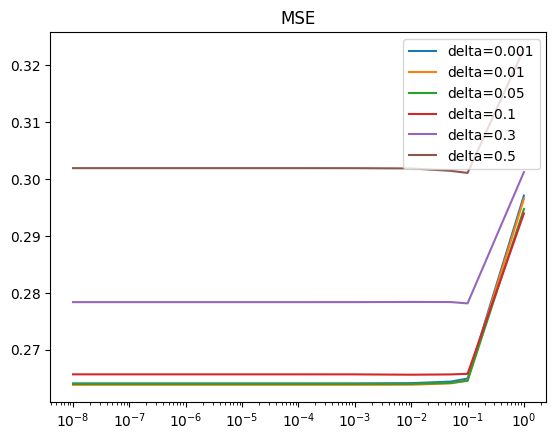

In [63]:
for model_name, mse in mses.items():
    plt.plot(NOISE_DELTAS, mse, label=model_name)
plt.xscale('log')
plt.legend()
plt.title("MSE")
plt.show()

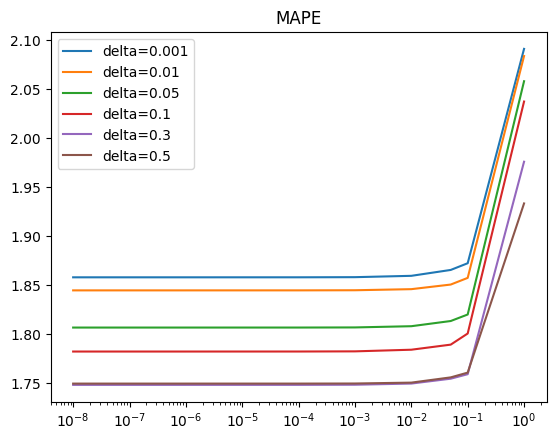

In [64]:
for model_name, mape in mapes.items():
    plt.plot(NOISE_DELTAS, mape, label=model_name)
plt.xscale('log')
plt.legend()
plt.title("MAPE")
plt.show()